# Analysis

In [1]:
# Imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Variables

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [2]:
# Load datasets
store = pd.read_csv('data/raw/store.csv')
train = pd.read_csv('data/raw/train.csv', low_memory=False)
test = pd.read_csv('data/raw/test.csv')

In [3]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


### Preprocessing

In [6]:
convert_store = {'StoreType': {'a': 0, 'b': 1, 'c': 2, 'd': 3},
                 'Assortment': {'a': 0, 'b': 1, 'c': 2}}
store.replace(convert_store, inplace=True)

In [7]:
store['PromoInterval'] = store['PromoInterval'].astype('category').cat.codes

In [8]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,-1
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,1
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,1
3,4,2,2,620.0,9.0,2009.0,0,NaN,NaN,-1
4,5,0,0,29910.0,4.0,2015.0,0,NaN,NaN,-1


## Analysis store

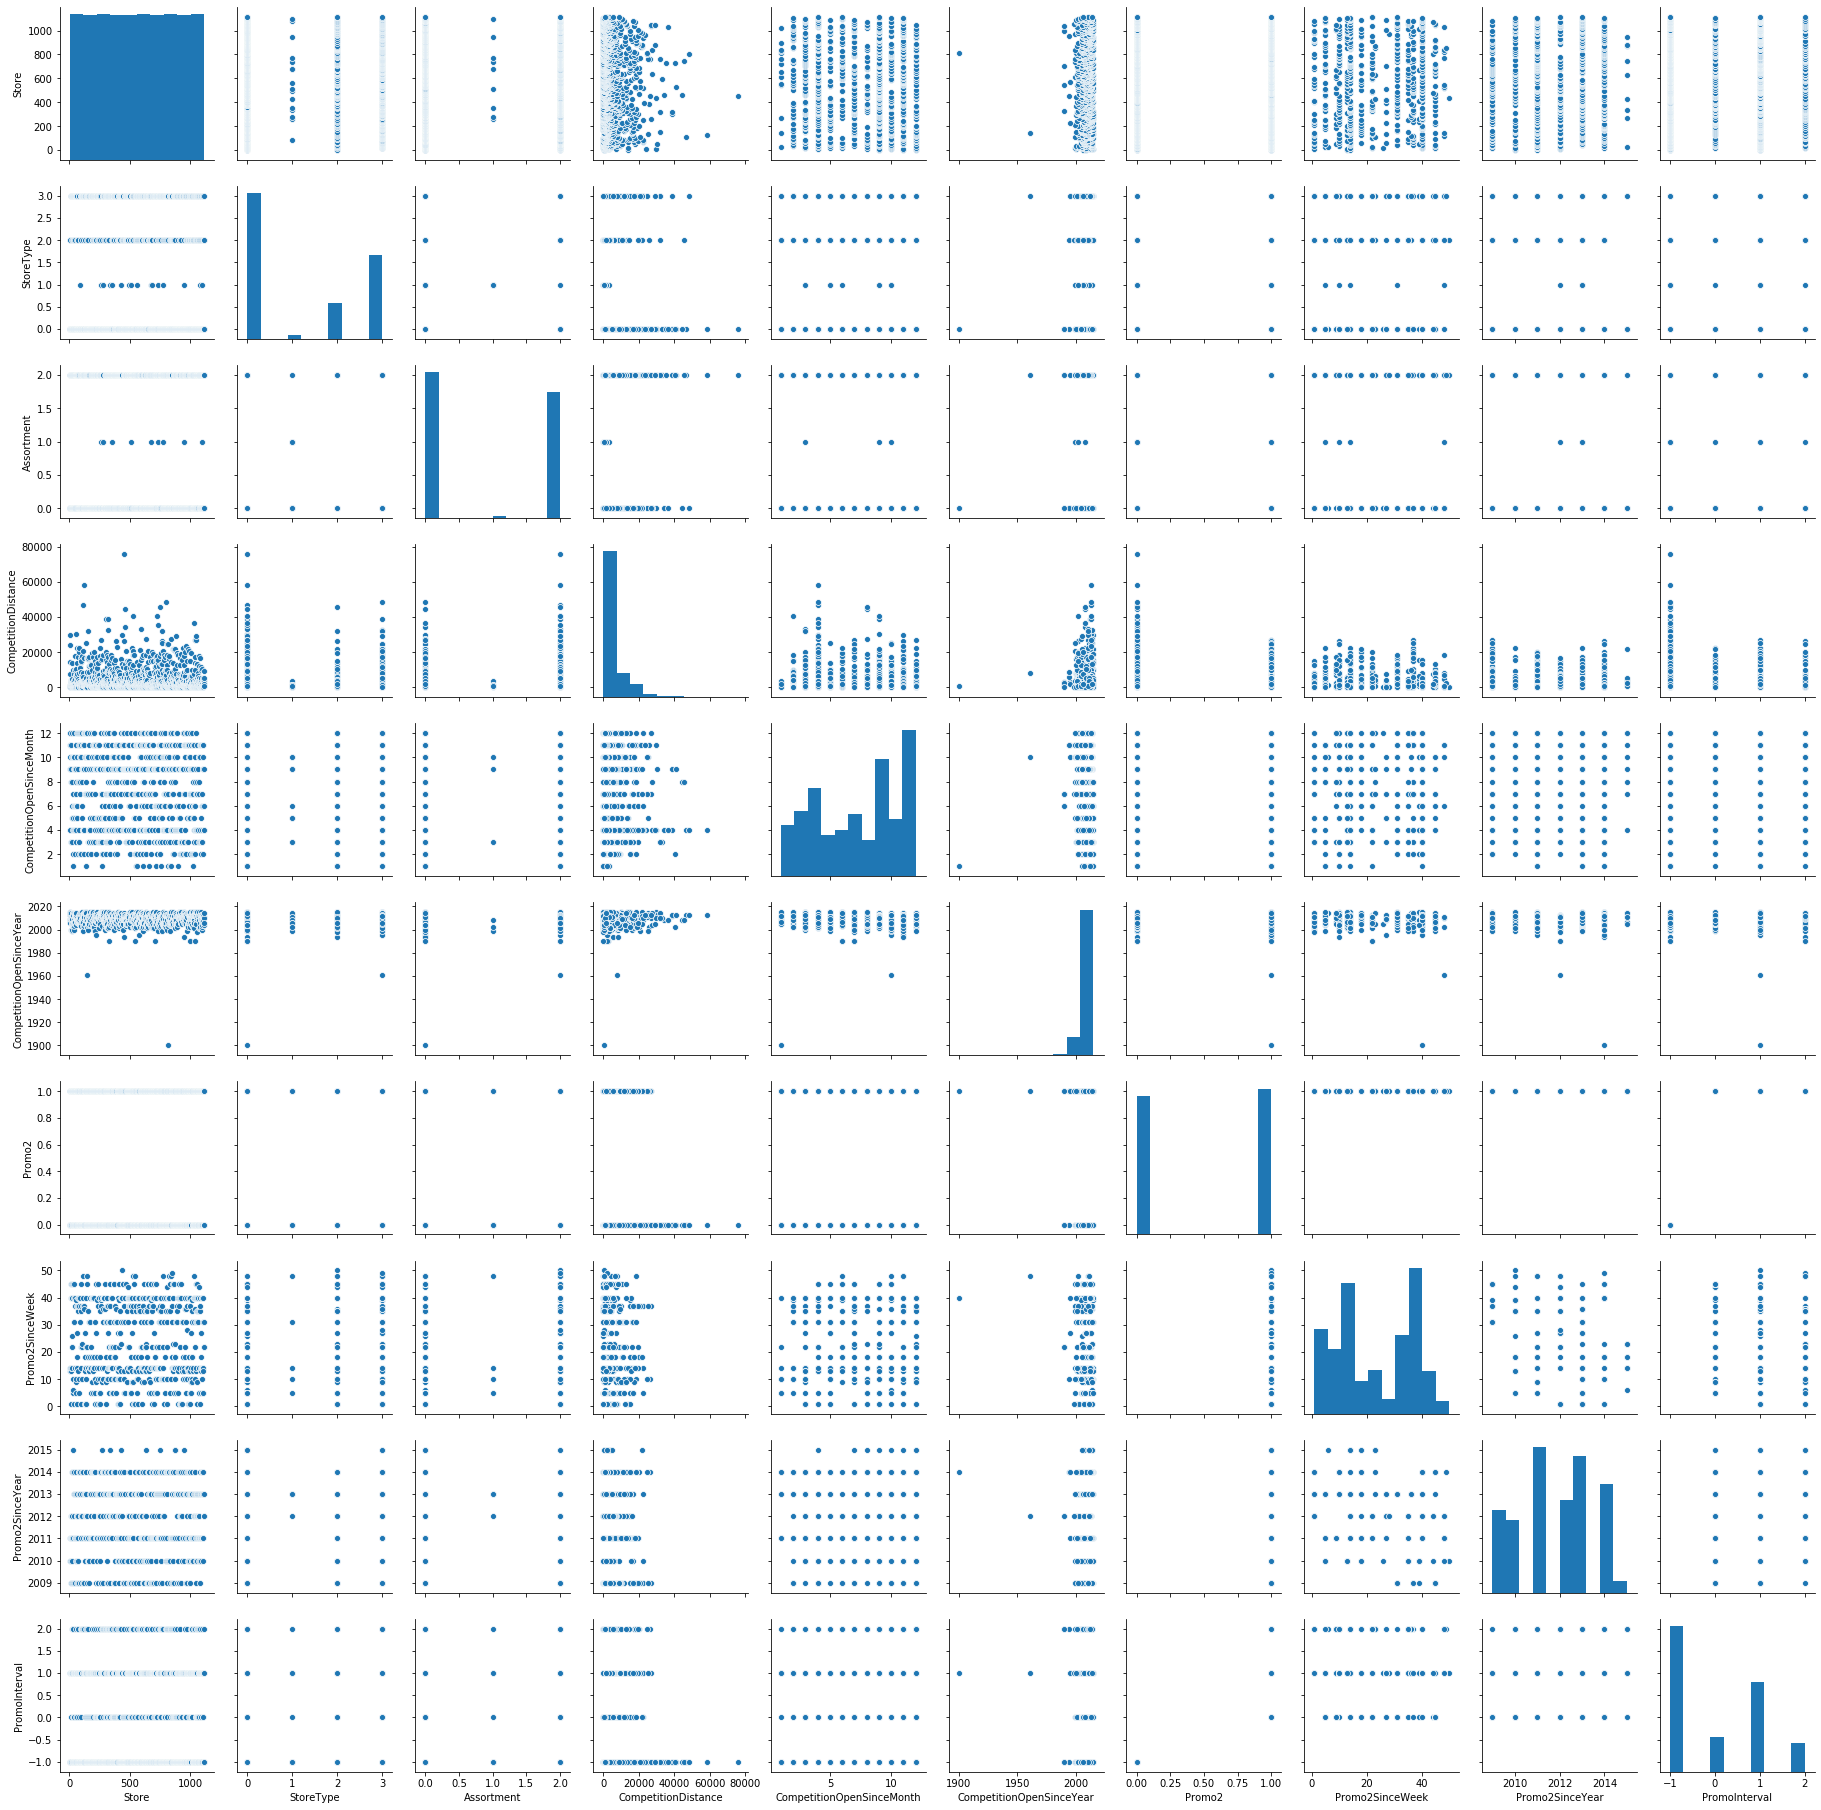

In [9]:
sns.pairplot(store)#, hue='StoreType')

## Analysis train

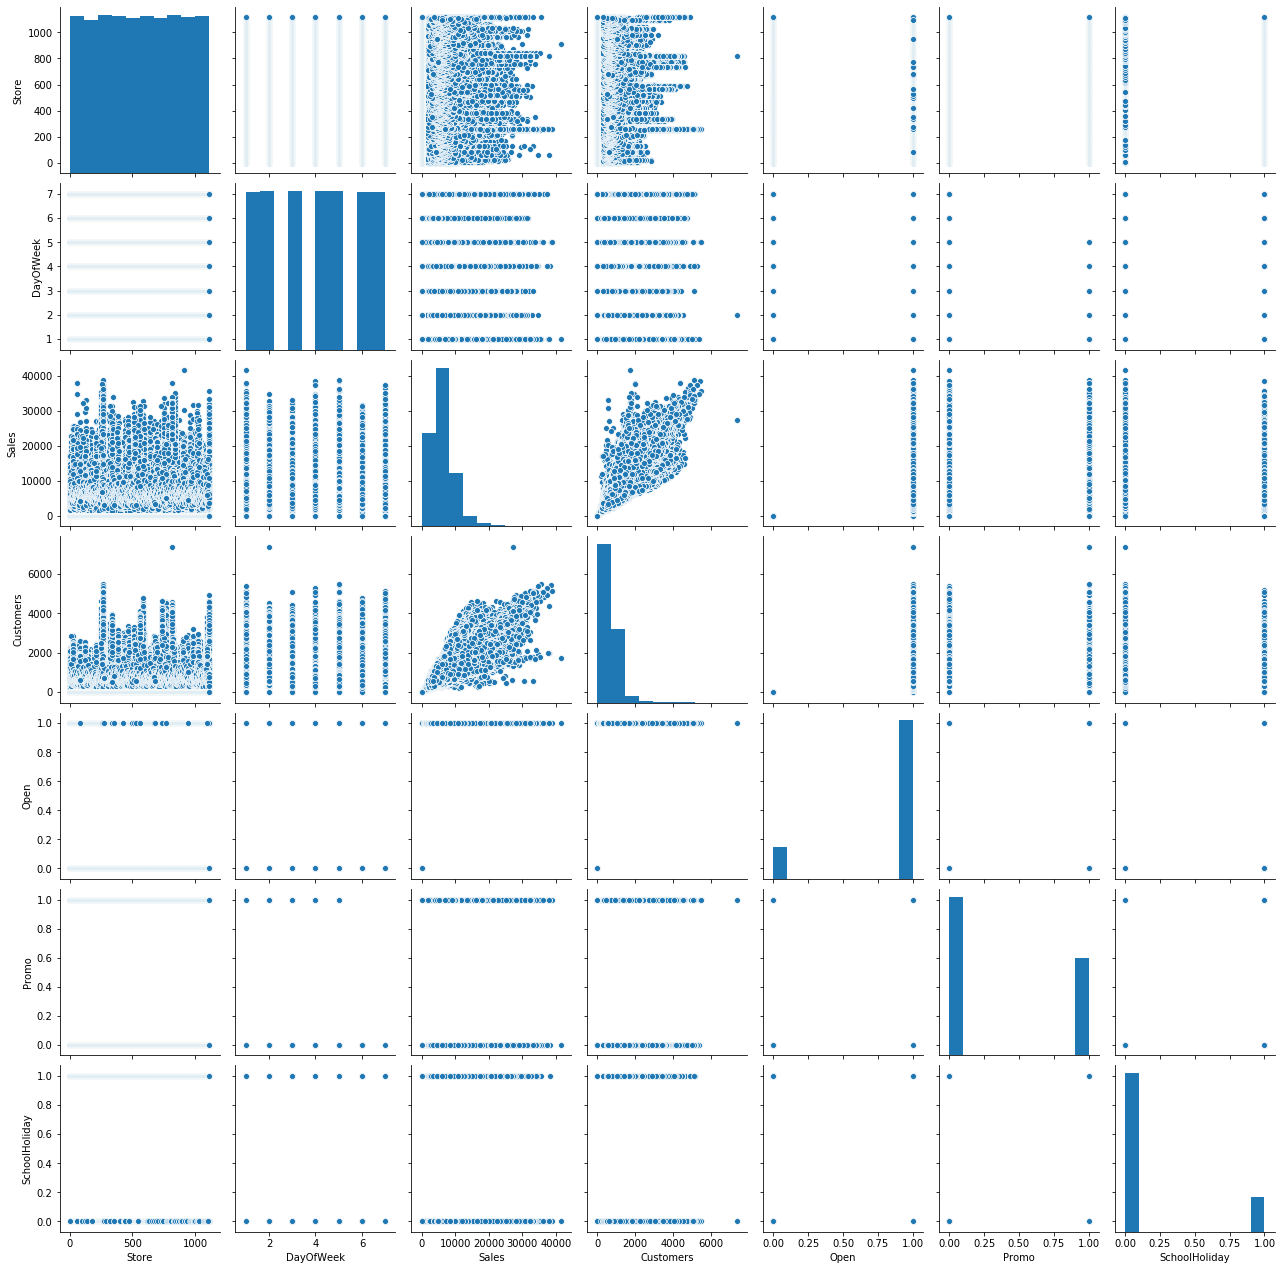

In [10]:
sns.pairplot(train)

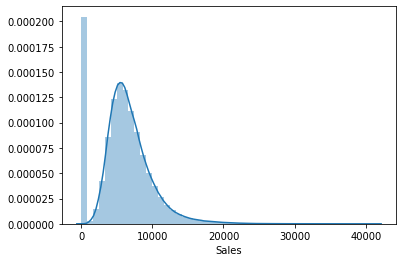

In [11]:
#sns.distplot(train[train['Sales'] != 0]['Sales'])
sns.distplot(train['Sales'])

## Merge datasets

In [12]:
merge_train = train.merge(store, left_on='Store', right_on='Store')
merge_test = test.merge(store, left_on='Store', right_on='Store')

In [13]:
merge_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,-1
1,1,4,2015-07-30,5020,546,1,1,0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,-1
2,1,3,2015-07-29,4782,523,1,1,0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,-1
3,1,2,2015-07-28,5011,560,1,1,0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,-1
4,1,1,2015-07-27,6102,612,1,1,0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,-1


In [14]:
merge_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,2,0,1270.0,9.0,2008.0,0,NaN,NaN,-1
1,857,1,3,2015-09-16,1.0,1,0,0,2,0,1270.0,9.0,2008.0,0,NaN,NaN,-1
2,1713,1,2,2015-09-15,1.0,1,0,0,2,0,1270.0,9.0,2008.0,0,NaN,NaN,-1
3,2569,1,1,2015-09-14,1.0,1,0,0,2,0,1270.0,9.0,2008.0,0,NaN,NaN,-1
4,3425,1,7,2015-09-13,0.0,0,0,0,2,0,1270.0,9.0,2008.0,0,NaN,NaN,-1


## Analysis merges

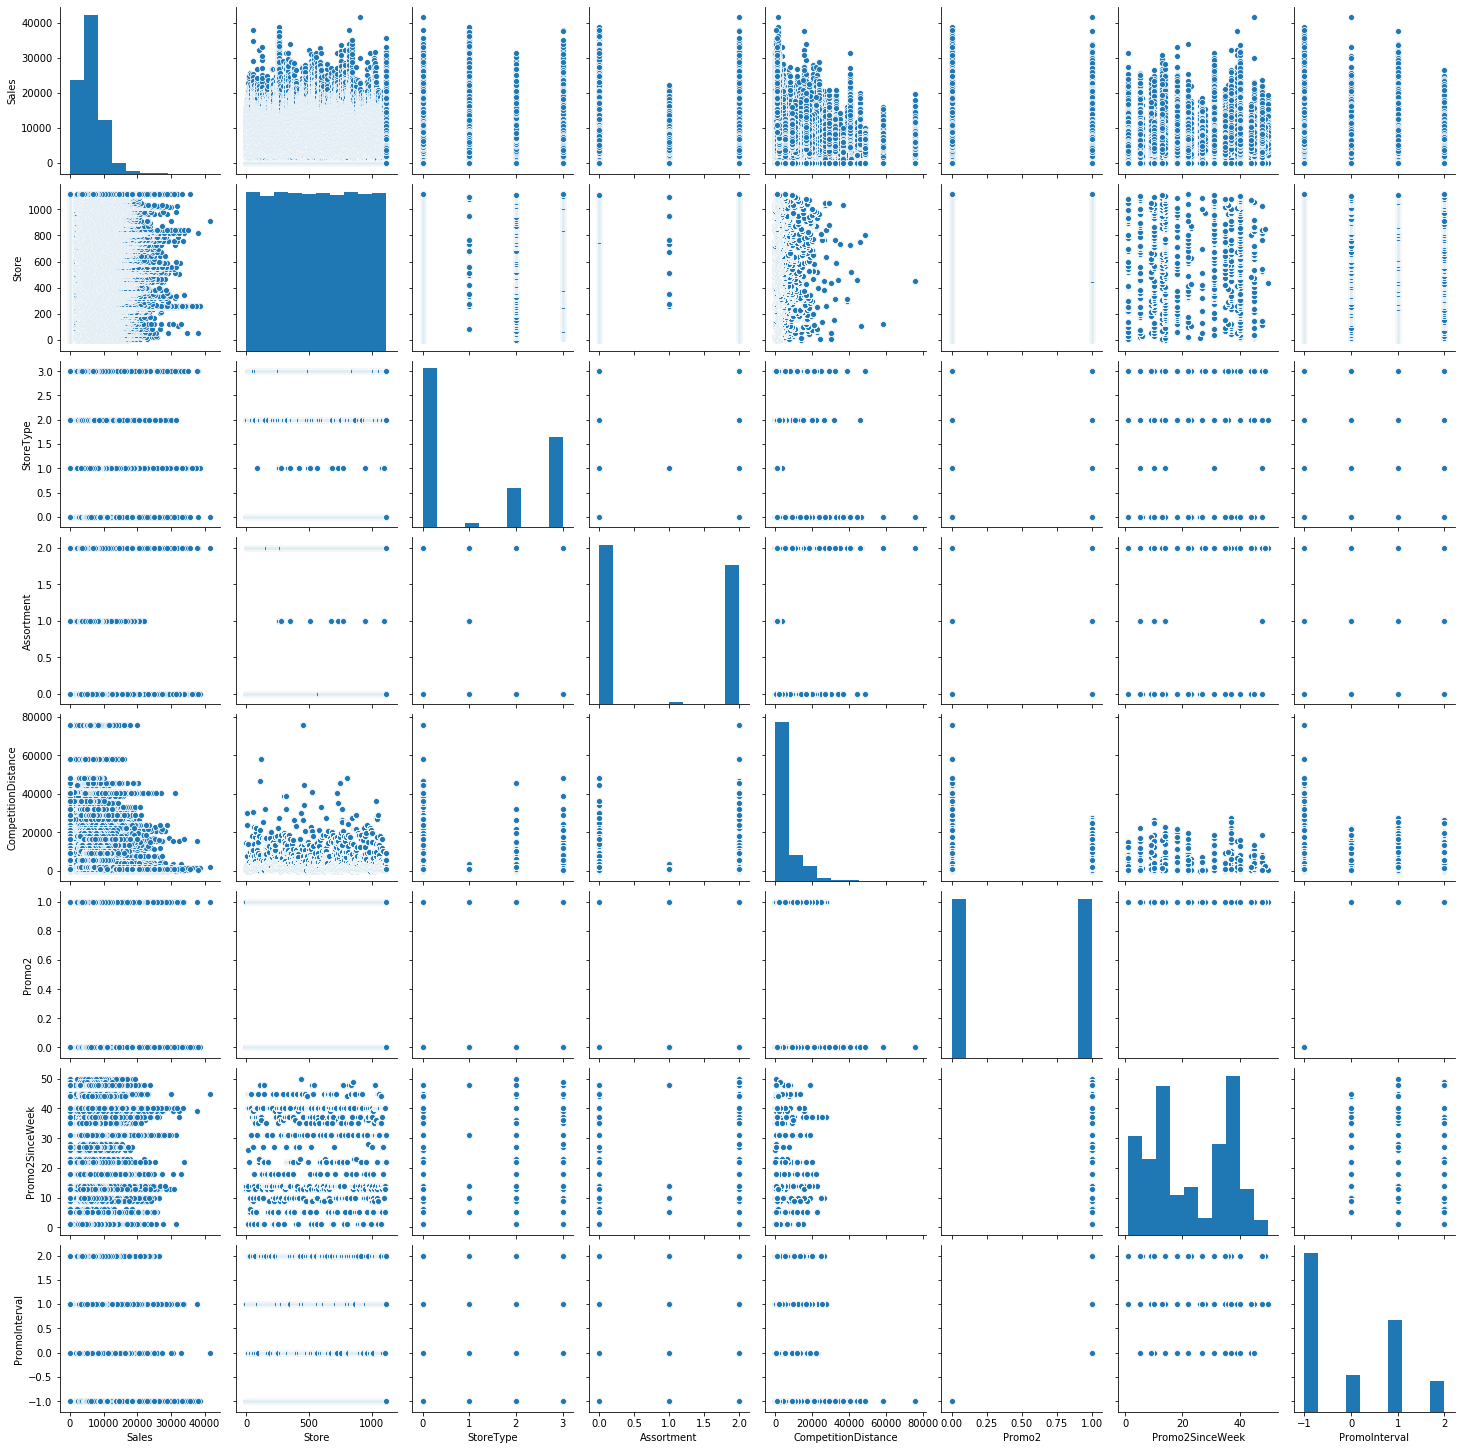

In [15]:
columns_to_plot = ['Sales', 'Store', 'StoreType', 'Assortment', 'CompetitionDistance', 
                   'Promo2', 'Promo2SinceWeek', 'PromoInterval']
sns.pairplot(merge_train[columns_to_plot])